<a href="https://colab.research.google.com/github/AshrithSagar/CP260-RP-2025/blob/main/2_lab_260_2025_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Lab 2: Particle Filters**

Reference:

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb

Chapter 8 of "Probabilistic robotcs, Thrun"



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [14]:
def create_uniform_particles(x_range, y_range, hdg_range, N):
  '''Uniform distributin of particles
  x_range: (min, max)
  y_range: (min, max)
  hdg_range: (min, max)
  N: number of particles
  '''
  particles = np.empty((N, 3))
  particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
  particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
  particles[:, 2] = np.random.uniform(hdg_range[0], hdg_range[1], size=N)
  particles[:, 2] %= 2 * np.pi
  weights = np.ones(N)/N
  return particles,weights

def plot_particles(particles):
  plt.scatter(particles[:,0],particles[:,1],s=0.1,color='r')
  plt.show()

In [15]:
def predict_particles(particles, u, std, dt=0.1):
  """ move according control input
  particle: numpy array of particles with (x,y,ang)
  u : control input(linear speed, angular speed)
  std: std. deviation of process noise (dist std, ang std)
  dt: time step
  returns
  updated list of particles
  """

  N = len(particles)
  # update heading
  particles[:, 2] += u[1]*dt + (np.random.randn(N) * std[1])
  particles[:, 2] %= 2 * np.pi

  # move each in the (noisy) commanded direction
  dist = (u[0] * dt) + (np.random.randn(N) * std[0])
  particles[:, 0] += np.cos(particles[:, 2]) * dist
  particles[:, 1] += np.sin(particles[:, 2]) * dist
  return particles



def update_true_pose(pose,u, dt=0.1):
  '''update the true pose
  pose: (x,y,ang)
  u: (linear velocity, angular velocity)
  std: (linear noise, angular noise)
  dt: time step
  return
  updated pose
  '''
  # update heading
  pose[2] += u[1]*dt
  pose[2] %= 2 * np.pi

  # move in the commanded direction
  dist = (u[0] * dt)
  pose[0] += np.cos(pose[2]) * dist
  pose[1] += np.sin(pose[2]) * dist
  return pose

def make_measurements(pose, mapL, dist_range=4.0, R=R):
  ''' make measurements of the land from the given pose
  pose: current pose
  mapL: list of landmarks (x,y) with their ids
  dist_range: only landmarks withing dist_range of pose will be measured
  ang_range: only landmarks in the relative angle range of pose will be measured (120)
  R: Measurement std deviation (distance, angle), with zero mean gaussian

  return
  Z: (x, y, ang, landmark id) of measurements
  '''
  Z=[]
  dstd=R[0]
  astd=R[1]
  for lid in mapL: #iterate through all landmarks
    lx,ly = mapL[lid]
    if (np.linalg.norm(pose[0:2]-np.array([lx,ly])) < dist_range):
      #landmark within measurement range
      ang = np.arctan2(ly-pose[1],lx-pose[0])-pose[2] + (np.random.randn() * astd)
      if (ang > np.pi):
        ang -= 2*np.pi
      elif (ang < -np.pi):
        ang += 2*np.pi
      dist = np.linalg.norm(pose[0:2]-np.array([lx,ly])) + (np.random.randn() * dstd)
      Z.append([dist,ang,lid])
  return np.array(Z)


[[ 1.88834246 -2.74306708  0.        ]
 [ 1.71495413 -2.2025452   1.        ]
 [ 1.86386765  2.75580029  3.        ]
 [ 1.69763349  2.17838664  4.        ]
 [ 2.78230093  1.42153264  5.        ]]
[[ 2.82210431 -2.88228371  0.        ]
 [ 2.29540851 -2.55225897  1.        ]
 [ 2.8356943   2.8904505   3.        ]
 [ 2.29592983  2.54591945  4.        ]
 [ 2.92059878  1.78669204  5.        ]]
[[ 3.90831655 -2.95552137  0.        ]
 [ 3.38150616 -2.72153696  1.        ]
 [ 3.74246793  2.96079623  3.        ]
 [ 3.36400679  2.69916379  4.        ]
 [ 3.2433826   2.08158642  5.        ]]
[[3.73141581 2.30311771 5.        ]]
[]
[]
[]
[[3.90636083 1.2627703  8.        ]]
[[3.50049768 1.52793219 8.        ]]


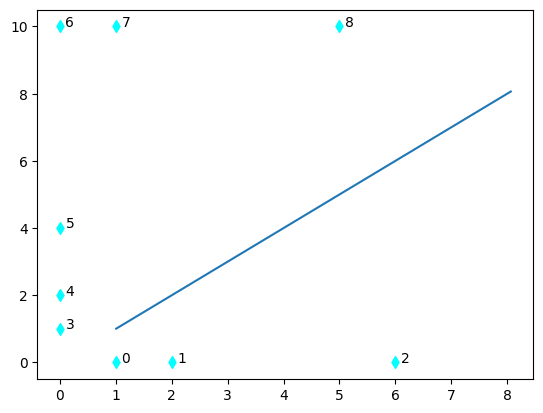

In [16]:
#list of landmarks
mapL={
    0:[1,0],
    1:[2,0],
    2:[6,0],
    3:[0,1],
    4:[0,2],
    5:[0,4],
    6:[0,10],
    7:[1,10],
    8:[5,10]
}

dt=0.1 #s of time step
NT=1000 # time steps of each of size dt

pose = np.zeros((NT,3))
pose[0]=(1,1,np.pi/4) #initially pointing along diagonal

u = (0.1,0) #go in a straight line withe speed of 1m/s

for i in np.arange(1,NT):
  pose[i] = update_true_pose(pose[i-1],u,dt)
  Z = make_measurements(pose[i],mapL)
  if i % 100 == 0:
    print(Z)

fig,ax = plt.subplots()
lmrk = np.array(list(mapL.values()))
ax.scatter(lmrk[:,0],lmrk[:,1],marker="d",c="cyan")
for lid in mapL:
  ax.annotate(str(lid), (mapL[lid][0]+0.1,mapL[lid][1]))
ax.plot(pose[:,0],pose[:,1])
plt.show()

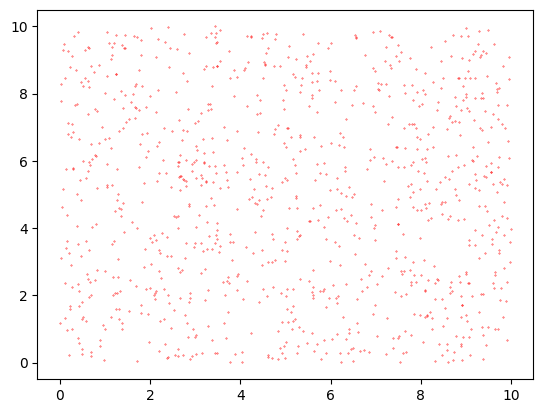

[[1.         1.         0.78539816]
 [4.57135002 9.21407814 4.26261603]
 [0.9480416  1.11524949 2.36299287]
 ...
 [1.70404213 9.6895932  4.73777232]
 [7.45503146 6.41517254 1.40620702]
 [0.36808677 8.69075917 3.76885716]]


In [17]:
u = (0.1,0) #go in a straight line withe speed of 1m/s
dstd = 0.1
astd = 0.01
R = np.array([dstd,astd])

#Number of particles
NP =1000

#number of simulation time steps
NT = 2

pose = np.zeros((NT,3))
pose[0]=(1,1,np.pi/4) #initially pointing along diagonal

u = (0.1,0) #go in a straight line withe speed of 1m/s

#create particles and weights
particles,weights = create_uniform_particles((0,10),(0,10),(0,2*np.pi),NP)
particles[0] = pose[0]
plot_particles(particles)
print(particles)

In [18]:


def simple_resample(particles, weights):
  N = len(particles)
  cumulative_sum = np.cumsum(weights)
  cumulative_sum[-1] = 1. # avoid round-off error
  indexes = np.searchsorted(cumulative_sum, np.random.random(N))
  return indexes


def Neff(weights):
  '''
  return effective number of particles, calculated
  as a function of inverse sum of weights square
  '''
  return 1.0/np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
  particles[:] = particles[indexes]
  weights.resize(len(particles))
  weights.fill(1.0 / len(weights))
  return particles, weights

def moments(particles, weights):
  '''
  return the mean and covariance of the weighted particles
  '''
  mean = np.average(particles, weights=weights, axis=0)
  cov = np.average((particles - mean)**2, weights=weights, axis=0) #not quite correct
  return mean, cov


---
**Question**

Complete the functions

In [19]:
def low_variance_resample(particles, weights):
    N = len(weights)
    indexes = np.zeros(N, dtype=int)
    cumulative_sum = np.cumsum(weights)
    r = np.random.rand() * (1 / N)
    j = 0
    for i in range(N):
        u = r + i * (1 / N)
        while u > cumulative_sum[j]:
            j += 1
        indexes[i] = j % N
    return indexes


def adaptive_low_variance_resample(particles, weights, wslow, wfast):
    N = len(weights)
    Neff = 1.0 / np.sum(np.square(weights))
    alpha_slow, alpha_fast = 0.001, 0.1
    wslow_next = wslow + alpha_slow * (Neff - wslow)
    wfast_next = wfast + alpha_fast * (Neff - wfast)
    if wfast_next < wslow_next:
        return low_variance_resample(particles, weights)
    else:
        return np.arange(N)  # No resampling


def update_particle_weights(particles, weights, Z, R, mapL):
    """update the weights with measurement likelihood
    particles: Nx3 array of particles with x,y, ang
    weights: Nx1 array of weight for each particle
    Z: M x 3 (range, ang, landmark id) is the set of measurements
    R: measurement noise covariance R[0]: distance cov, R[1]: ang covariance
    mapL: L x 2 (lx, ly) location of landmarks in the map
    returns
    updated weights (multiplied by likelihood)
    """
    # for each measurement
    for zdist, zang, zid in Z:
        lx, ly = mapL[zid]
        for i in range(len(particles)):
            dx = lx - particles[i, 0]
            dy = ly - particles[i, 1]
            expected_dist = np.sqrt(dx**2 + dy**2)
            expected_ang = (np.arctan2(dy, dx) - particles[i, 2]) % (2 * np.pi)
            # Measurement likelihood (Gaussian)
            dist_error = (zdist - expected_dist) / R[0]
            ang_error = (zang - expected_ang) / R[1]
            weights[i] *= np.exp(-0.5 * (dist_error**2 + ang_error**2))
    # end for
    weights += 1.0e-16  # avoid round-off to zero
    weights /= sum(weights)
    return weights

---
**Question**

Complete the code to simulate tracking/localization

Do for the three kinds of resampler and explain the results

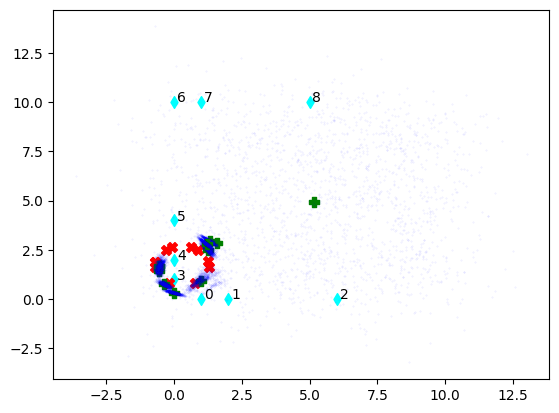

In [20]:
NP=1000 #number of particles
NT=1000 #number of time steps for simulation
dt=0.1 #time step

u = (0.1,0.1) #go in a straight line withe speed of 1m/s

P = np.array([0.1,0.1]) #linear, angular std deviation for process model

dstd = 0.5
astd = 0.5
R = np.array([dstd,astd]) #distance, angle std deviation for measurement


fig,ax = plt.subplots()
lmrk = np.array(list(mapL.values()))
ax.scatter(lmrk[:,0],lmrk[:,1],marker="d",c="cyan")
for lid in mapL:
  ax.annotate(str(lid), (mapL[lid][0]+0.1,mapL[lid][1]))


pose = np.zeros((NT+1,3))
pose[0]=(1,1,np.pi/4) #initially pointing along diagonal
particles,weights = create_uniform_particles((0,10),(0,10),(0,2*np.pi),NP)

#average of slow/fast weights for adaptive resampling
wslow = np.average(weights)
wfast = np.average(weights)
a_slow=1/100.0
a_fast=1/10.0


mean = np.zeros((NT+1,3))
mean[0],_ = moments(particles,weights)

for i in np.arange(0,NT):
  particles = predict_particles(particles, u, P, dt)
  pose[i+1] = update_true_pose(pose[i], u, dt)
  Z = make_measurements(pose[i+1], mapL, dist_range=4.0, R=R)
  weights = update_particle_weights(particles, weights, Z, R, mapL)
  mean[i+1], _ = moments(particles, weights)

  if ((i+1) % 100 == 0): #plot
    ax.scatter(pose[i+1,0],pose[i+1,1],s=50.0,marker="X", c="r")
    ax.scatter(mean[i+1,0],mean[i+1,1],s=50.0,marker="P", c="g")
    ax.scatter(particles[:,0],particles[:,1],s=0.1,c='b',alpha=0.1)

  # Resampling
  indexes = adaptive_low_variance_resample(particles, weights, wslow, wfast)
  particles, weights = resample_from_index(particles, weights, indexes)

  wslow = wslow + a_slow * (1.0 / np.sum(np.square(weights)) - wslow)
  wfast = wfast + a_fast * (1.0 / np.sum(np.square(weights)) - wfast)

ax.scatter(pose[-1,0],pose[-1,1],s=50.0,marker="X", c="r")
ax.scatter(mean[-1,0],mean[-1,1],s=50.0,marker="P", c="g")
ax.scatter(particles[:,0],particles[:,1],s=0.1,c='b',alpha=0.1)
plt.show()

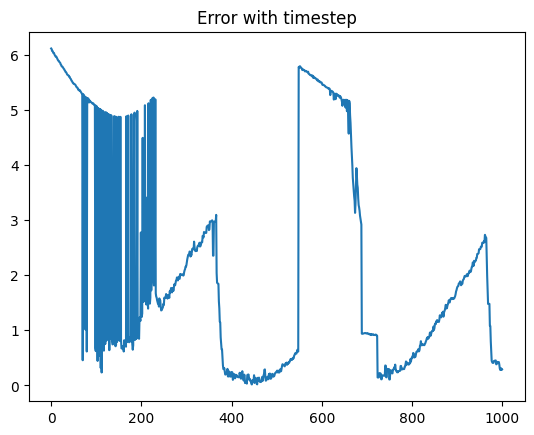

In [21]:
plt.title("Error with timestep")
plt.plot(np.linalg.norm(mean-pose, axis=1))
plt.show()